In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [26]:
#Read final dataset for work
path="/home/dmacs/Downloads/Mini_Project/Beth_dataset/labelled_training_data.csv"  # Path is the dataset path. copy path from the drive and paste here
df=pd.read_csv(path,low_memory=False)

df1 = pd.read_csv("/home/dmacs/Downloads/Mini_Project/Beth_dataset/labelled_testing_data.csv")
df2 = pd.read_csv("/home/dmacs/Downloads/Mini_Project/Beth_dataset/labelled_validation_data.csv")

df = df.append(df1)
df = df.append(df2)


/tmp/ipykernel_170824/3245023583.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df1)
/tmp/ipykernel_170824/3245023583.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2)


In [27]:
df.columns

Index(['timestamp', 'processId', 'threadId', 'parentProcessId', 'userId',
       'mountNamespace', 'processName', 'hostName', 'eventId', 'eventName',
       'stackAddresses', 'argsNum', 'returnValue', 'args', 'sus', 'evil'],
      dtype='object')

In [28]:
df_with_evil = df.copy()

In [29]:
# train_data = pd.DataFrame(train_final_no_duplicates[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])
df = pd.DataFrame(df[["hostName","processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue","sus"]])

In [30]:
df.columns

Index(['hostName', 'processId', 'parentProcessId', 'userId', 'mountNamespace',
       'eventId', 'argsNum', 'returnValue', 'sus'],
      dtype='object')

In [58]:
# del df['eventName']
# del df['stackAddresses']
# del df['args']
# del df['processName']
# # del df['Unnamed: 0']

In [13]:
df.head()

,hostName,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus
0,ip-10-100-1-120,381,1,100,4026532231,157,5,0,1
1,ip-10-100-1-120,381,1,100,4026532231,3,1,0,1
2,ip-10-100-1-120,381,1,100,4026532231,1010,0,0,1
3,ip-10-100-1-120,7347,7341,0,4026531840,21,2,-2,1
4,ip-10-100-1-120,7347,7341,0,4026531840,1005,4,0,1


In [31]:
#Target column encoding
from sklearn import preprocessing

def encode_text_index(df,name):
  le = preprocessing.LabelEncoder()
  df[name] = le.fit_transform(df[name])
  return le.classes_

In [32]:
#Target column encoding
#def encode_text_index(df,name):
le = preprocessing.LabelEncoder()
le.fit_transform(df['hostName'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'ip-10-100-1-120': 0, 'ip-10-100-1-129': 1, 'ip-10-100-1-165': 2, 'ip-10-100-1-169': 3, 'ip-10-100-1-173': 4, 'ip-10-100-1-217': 5, 'ip-10-100-1-28': 6, 'ip-10-100-1-34': 7, 'ip-10-100-1-55': 8, 'ip-10-100-1-57': 9, 'ip-10-100-1-79': 10, 'ubuntu': 11}


In [33]:
#Encoding the numeric column
def  encode_numeric_zscore(df, name, mean=None, sd=None):
  if mean is None:
    mean= df[name].mean()

  if sd is None:
    sd=df[name].std()

  df[name] = (df[name] - mean) / sd

In [34]:
def process_data(unprocessed_data):
    data = unprocessed_data.copy()
    data["processId"] = data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    data["parentProcessId"] = data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    data["userId"] = data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
    data["mountNamespace"] = data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
    data["eventId"] = data["eventId"]  # Keep eventId values (requires knowing max value)
    data["returnValue"] = data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error

    return data

In [35]:
df = process_data(df)

In [63]:
# encode_numeric_zscore(df,'mountNamespace')
encode_numeric_zscore(df,'threadId')
# encode_numeric_zscore(df,'processId')
# encode_numeric_zscore(df,'timestamp')
# encode_numeric_zscore(df,'parentProcessId')
# encode_numeric_zscore(df,'eventId')
# encode_numeric_zscore(df,'returnValue')

In [36]:
hostNmae = encode_text_index(df,'hostName')
df.head()

,hostName,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus
0,0,1,0,0,1,157,5,0,1
1,0,1,0,0,1,3,1,0,1
2,0,1,0,0,1,1010,0,0,1
3,0,1,1,0,0,21,2,2,1
4,0,1,1,0,0,1005,4,0,1


In [37]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [38]:
# Convert to numpy - Classification
# x_columns = df.columns.drop('evil')
x_columns = df.columns
x = df[x_columns].values

dummies = pd.get_dummies(df_with_evil['evil']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)

y = dummies.values

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle = True, random_state=64)

In [44]:
#model
import tensorflow as tf
constraints = tf.keras.constraints.UnitNorm(axis=0)

initializer = tf.keras.initializers.GlorotUniform()

model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, input_dim=x.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu'),
      tf.keras.layers.Dense(64, input_dim=x.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=x.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dense(y.shape[1],activation='softmax')
      ])

/home/dmacs/.local/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [73]:
! pip install -q tensorflow-model-optimization

In [45]:
import datetime 
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

monitor = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=8, verbose=1, mode='auto',restore_best_weights=True),
            ]
# tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history  = model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2, batch_size=256, epochs=100)  


2024-02-15 18:33:36.311702: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65726064 exceeds 10% of free system memory.


Epoch 1/100


2024-02-15 18:33:46.154260: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16431552 exceeds 10% of free system memory.


3566/3566 - 10s - loss: 0.0641 - accuracy: 0.9890 - val_loss: 0.0144 - val_accuracy: 0.9967 - 10s/epoch - 3ms/step
Epoch 2/100
3566/3566 - 8s - loss: 0.0243 - accuracy: 0.9948 - val_loss: 0.0164 - val_accuracy: 0.9956 - 8s/epoch - 2ms/step
Epoch 3/100
3566/3566 - 8s - loss: 0.0180 - accuracy: 0.9958 - val_loss: 0.0152 - val_accuracy: 0.9957 - 8s/epoch - 2ms/step
Epoch 4/100
3566/3566 - 8s - loss: 0.0139 - accuracy: 0.9967 - val_loss: 0.0097 - val_accuracy: 0.9972 - 8s/epoch - 2ms/step
Epoch 5/100
3566/3566 - 8s - loss: 0.0125 - accuracy: 0.9968 - val_loss: 0.0063 - val_accuracy: 0.9985 - 8s/epoch - 2ms/step
Epoch 6/100
3566/3566 - 8s - loss: 0.0094 - accuracy: 0.9977 - val_loss: 0.0062 - val_accuracy: 0.9973 - 8s/epoch - 2ms/step
Epoch 7/100
3566/3566 - 8s - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.0235 - val_accuracy: 0.9955 - 8s/epoch - 2ms/step
Epoch 8/100
3566/3566 - 8s - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.0052 - val_accuracy: 0.9987 - 8s/epoch - 2ms/step
Epoch 9/10

In [46]:
yhat_probs = model.predict(x_test, verbose=0)


2024-02-15 18:36:12.077559: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16431552 exceeds 10% of free system memory.


In [47]:
yhat_probs

array([[9.9998575e-01, 1.4195424e-05],
       [9.9988335e-01, 1.1657623e-04],
       [9.9999839e-01, 1.5313599e-06],
       ...,
       [9.9991065e-01, 8.9291068e-05],
       [9.9969208e-01, 3.0792181e-04],
       [9.9991161e-01, 8.8323381e-05]], dtype=float32)

In [48]:
from sklearn.metrics import confusion_matrix

y_pred_labels = np.argmax(yhat_probs, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[196377     77]
 [   219  31543]]


In [49]:
from sklearn.metrics import roc_auc_score

# Assuming y_test contains the true labels (in binary format) and yhat_probs contains the predicted probabilities
# Convert probabilities to binary predictions
y_pred_probs = yhat_probs[:, 1]  # Assuming the second column contains the probabilities for the positive class

# Reshape y_pred_probs to a 2D array with one column
y_pred_probs = y_pred_probs.reshape(-1, 1)

# Calculate AUROC
auroc = roc_auc_score(y_test, y_pred_probs)

print("AUROC Score:", auroc)


AUROC Score: 5.593561798550279e-05


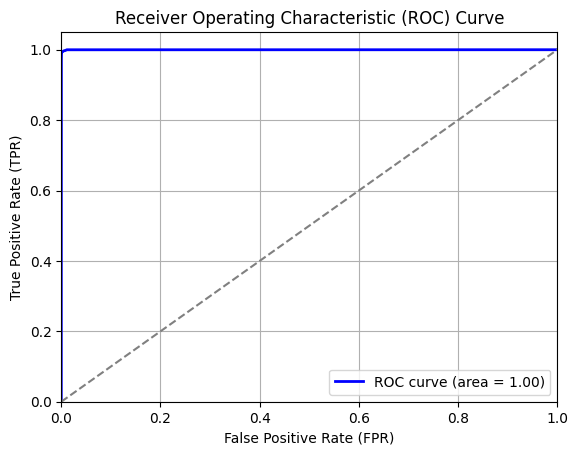

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

binary_labels = (y_test[:, 1] == 1).astype(int) 
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(binary_labels, y_pred_probs)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [51]:
import numpy as np

# Convert multilabel-indicator to binary labels
binary_labels = np.argmax(y_test, axis=1)

# Now you can compute classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Compute accuracy
accuracy = accuracy_score(binary_labels, y_pred_labels)

# Compute precision
precision = precision_score(binary_labels, y_pred_labels)

# Compute recall
recall = recall_score(binary_labels, y_pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.9987029831387808
Precision: 0.9975648323845667
Recall: 0.9931049682009949


Before Making Changes(Pre Processing changes)

Accuracy: 0.9987424194622638

Precision: 0.9980694369718645

Recall: 0.9928845790567344